# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Read Dataset

In [2]:
#Read datasets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')
#Read test datasets
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Fix metric on ceiling_height_agl:m and cloud_base_agl:m

Found that most likely the **ceiling_height_agl:m** and **cloud_base_agl:m** starts with values in meters, and then suddenly switches into using feet at 26.03.2020. Therefore I transform the values before 26.03.2020 into feet. 

In [3]:
mask_a = X_train_observed_a['date_forecast'] < '2020-03-26'
mask_b = X_train_observed_b['date_forecast'] < '2020-03-26'
mask_c = X_train_observed_c['date_forecast'] < '2020-03-26'

# Apply the conversion from meters to feet (1 meter = 3.28084 feet)
conversion_factor = 3.28084

X_train_observed_a.loc[mask_a, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'ceiling_height_agl:m'] *= conversion_factor

X_train_observed_a.loc[mask_a, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'cloud_base_agl:m'] *= conversion_factor

As the features have a 0.83 correlation, I choose to go forward with ceiling height

# Concat data and split into timeframes

In [4]:

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"
X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

#copy 23:45 value to 00:00 as it isn't there
def fill_last(frame):
    copy = frame.copy()

    copy["date_forecast"] = copy["date_forecast"] + pd.Timedelta(minutes=15)
    
    copy = copy[copy["date_forecast"].apply(lambda time : time.hour == 0 and time.minute == 0)]

    frame = pd.concat([
        frame,
        copy.astype(frame.dtypes)
    ])

    return frame.drop_duplicates(subset="date_forecast", keep="first")

#fill last
X_test_estimated_a = fill_last(X_test_estimated_a)
X_test_estimated_b = fill_last(X_test_estimated_b)
X_test_estimated_c = fill_last(X_test_estimated_c)

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c,
                     X_test_estimated_a,
                     X_test_estimated_b,
                     X_test_estimated_c], ignore_index=True)


#map snow density to one and zero
X_train_raw["snow_density:kgm3"] = X_train_raw["snow_density:kgm3"].apply(lambda a : np.isnan(a)).map({True: 0, False: 1})

#fix ceiling_height NaN values to -666 because the docs hints to it
#also rename the features with their proper metric and remove the old ones
X_train_raw["ceiling_height_agl:ft"] = X_train_raw["ceiling_height_agl:m"].fillna(-666)
X_train_raw["cloud_base_agl:ft"] = X_train_raw["cloud_base_agl:m"].fillna(-666)
X_train_raw.drop(columns=["ceiling_height_agl:m", "cloud_base_agl:m"], inplace=True)

#categorizing ceiling_height_agl:ft
X_train_raw['ceiling_height_agl:ft'] = pd.cut(X_train_raw['ceiling_height_agl:ft'], bins=[-1000, 0, 500, 1000, 3000, 5000, 12000, float('inf')], labels=[-666, 1, 2, 3, 4, 5, 6])
X_train_raw.drop(columns=["cloud_base_agl:ft"], inplace=True)

"""
#categorizing precip_type_5min:idx
#found this in the docs
precip_types = {
    0: "None",
    1: "Rain",
    2: "Rain_and_snow_mixed",
    3: "Snow",
    4: "Freezing_rain",
    5: "Hail",
}
#map the values to their labels
X_train_raw['precip_type_5min:idx'] = X_train_raw['precip_type_5min:idx'].map(precip_types)
"""

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

parse_dates = ['time']
X_test_targets = pd.read_csv("test.csv", parse_dates=parse_dates)
display(X_test_targets)
X_test_targets = X_test_targets.rename(columns = {"prediction" : "pv_measurement"})

train_a["id"] = -10
train_b["id"] = -10
train_c["id"] = -10


targets = pd.concat([train_a,
                     train_b,
                     train_c,
                     X_test_targets.astype(train_a.dtypes)]).dropna()

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

display(X_train_raw)

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,ceiling_height_agl:ft
0,2019-06-02 22:00:00,2019-06-02 21:00:00,7.7,1.230,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,98.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.799988,0.0,0.0,994.200012,1000.299988,0.0,0.0,73.099998,1006.299988,0,0.0,0.0,-0.0,0.1,342.834015,-3.202,0.0,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,A,5
1,2019-06-02 22:15:00,2019-06-02 21:15:00,7.7,1.229,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.500000,0.0,0.0,993.900024,999.900024,0.0,0.0,72.199997,1006.000000,0,0.0,0.0,-0.0,0.2,346.294006,-3.650,0.0,286.100006,100.000000,40123.898438,3.6,-3.6,-0.6,-0.0,A,5
2,2019-06-02 22:30:00,2019-06-02 21:30:00,7.7,1.228,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.199997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.099976,0.0,0.0,993.599976,999.599976,0.0,0.0,71.199997,1005.599976,0,0.0,0.0,-0.0,0.2,349.768005,-3.998,0.0,286.299988,100.000000,40628.300781,3.6,-3.6,-0.4,-0.0,A,5
3,2019-06-02 22:45:00,2019-06-02 21:45:00,7.7,1.226,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.799988,0.0,0.0,993.299988,999.299988,0.0,0.0,70.199997,1005.299988,0,0.0,0.0,-0.0,0.2,353.251007,-4.247,0.0,286.600006,100.000000,41153.601562,3.5,-3.5,-0.2,-0.0,A,5
4,2019-06-02 23:00:00,2019-06-02 22:00:00,7.7,1.225,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.500000,0.0,0.0,993.000000,999.000000,0.0,0.0,69.199997,1005.000000,0,0.0,0.0,-0.0,0.2,356.742004,-4.393,0.0,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,A,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413837,2023-06-18 07:00:05,2023-06-19 23:00:00,10.7,1.193,0.0,0.0,0.0,285.600006,0.0,0.0,0.0,0.0,27.799999,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1011.000000,0.0,0.0,995.299988,1001.200012,0.0,0.0,59.200001,1007.000000,0,0.0,0.0,-0.0,0.0,6.356000,-3.011,0.0,293.700012,43.500000,46996.800781,4.0,-2.0,3.5,-0.0,C,5
413838,2023-06-21 07:00:30,2023-06-22 23:00:00,9.4,1.228,0.0,0.0,0.0,283.299988,0.0,0.0,0.0,0.0,95.599998,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.0,0.0,997.799988,1003.799988,0.0,0.0,83.199997,1009.900024,0,0.0,0.0,-0.0,0.0,6.206000,-2.996,0.0,285.399994,96.800003,33542.898438,1.3,-0.6,1.1,-0.0,C,3
413839,2023-06-25 07:01:23,2023-06-26 23:00:00,9.8,1.187,0.0,0.0,0.0,284.200012,0.0,0.0,0.0,0.0,2.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.799988,0.0,0.0,989.200012,995.000000,0.0,0.0,53.099998,1000.799988,0,0.0,0.0,-0.0,0.0,6.015000,-3.071,0.0,295.500000,2.000000,48980.699219,3.1,-2.0,2.5,-0.0,C,-666
413840,2023-06-29 07:00:05,2023-06-30 23:00:00,9.3,1.220,0.0,0.0,0.0,283.100006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.000000,0.0,0.0,989.200012,995.200012,0.0,0.1,88.800003,1001.200012,0,0.0,0.0,-0.0,0.2,5.837000,-3.254,0.1,284.399994,100.000000,9935.700195,1.8,1.6,-0.9,0.0,C,3


# Define helper functions

In [5]:
#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#finds mode (typetall) for a row
def find_mode_with_priority(row, priority_list, max=False):
    # Check for prioritized values in the row and set it as the mode if it is
    for value in priority_list:
        if value in row.values:
            return value

    # Calculate the mode for the row
    if max:
        mode_value = row.mode().max()
    else:
        mode_value = row.mode().min()

    return mode_value

def add_most_frequent_feature(dataset, f15, f30, f45, f60, column_name, priority_list, max=False):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].apply(find_mode_with_priority, args=(priority_list, max), axis=1)

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

def add_accumulated(dataset, f15, f30, f45, f60, column_name, time_interval):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    time_multiplier = 15/time_interval

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].sum(axis=1)*time_multiplier

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

def add_accumulated_all(dataset, f15, f30, f45, f60, column_name, time_interval):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    time_multiplier = 15/time_interval

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    for feat in feature_names:
        dataset[feat] = dataset[feat]*time_multiplier

    return dataset


# Feature info

### Features removed because of correlations:

- **fresh_snow_12h:cm**: fresh_snow_24h:cm = **0.82**

- **fresh_snow_3h:cm**: fresh_snow_1h:cm = **0.81**

- **fresh_snow_6h:cm**: fresh_snow_24h:cm = **0.83**

- **diffuse_rad:W**: diffuse_rad_1h:J = **0.99**

- **direct_rad:W**: direct_rad_1h:J = **0.99**

- **pressure_100m:hPa**: msl_pressure:hPa = **1.00**

- **pressure_50m:hPa**: msl_pressure:hPa = **1.00**

- **sfc_pressure:hPa**: msl_pressure:hPa = **1.00**

- **absolute_humidity_2m:gm3**: t1000:hPa = **0.90**

- **air_density_2m:kgm3**: t1000:hPa = **0.90**

- **dew_point_2m:K**: t1000:hPa = **0.91**

- **clear_sky_rad:W**: sun_elevation = **0.83**

- **clear_sky_energy_1h:J**: sun_elevation = **0.82**

- **total_cloud_cover:p**: effective_cloud_cover:p = **0.94**

- **cloud_base_agl:m**: ceiling_height_agl:m = **0.83** (after recalculating to feet)

### High correlations still in the set:

- **is_day:idx**: sun_elevation = **0.81**

- **diffuse_rad_1h:J**: sun_elevation = **0.80**

### Other features removed:

- **snow_drift:idx**: Almost exclusively 0, so doesn't add much data

- **wind_speed_w_1000hPa:ms**: In relation to the dummy data found in the docs this data is really weird (binary as opposed to continous values)


# Add standardizable features

In [6]:
# SNOW AND PRECIPITATION

# tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h????
# dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")
# dataset = add_feature(dataset, features60, "fresh_snow_3h:cm")
# dataset = add_feature(dataset, features60, "fresh_snow_6h:cm")
# dataset = add_feature(dataset, features60, "fresh_snow_12h:cm")
dataset = add_feature(dataset, features60, "fresh_snow_24h:cm")

# tar alle akkumulerte verdier og ganger med 3 for å få en bedre verdi (ikke helt etter boka menmen...)
dataset = add_accumulated(dataset, features15, features30, features45, features60, "precip_5min:mm", 5)
# disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")
# tar akkumulert verdi og ganger med 3/2 for å få en bedre verdi (ikke helt etter boka menmen...)
dataset = add_accumulated(dataset, features15, features30, features45, features60, "snow_melt_10min:mm", 10)


# ACCUMULATIVE FEATURES

# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")
# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

# PRESSURE

# tar gjennomsnittet da dette er punktmålinger ##kan hende denne burde kjøres per kvarter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")


# TEMPERATURE

# gjennomsnitt siden variasjonen hvert kvarter sannsynligvis er lav? ##kan hende denne burde kjøres per kvarter
# update: kjører hvert kvarter
dataset = add_all(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")


# SUN

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")


# DAY AND SHADOW

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")


# CLOUDS

#gjennomsnitt fordi verdien er trolig momentan
#SANNSYNLIGVIS VELDIG VIKTIG
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")


# HUMIDITY AND RIME

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")
#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")


# WIND

# Gjennomsnitt fordi lite variabel #! try without
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_10m:ms")


# OTHERS (Up for discussion)
# Gjennomsnitt fordi?
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "super_cooled_liquid_water:kgm2")

# Standardize data

In [7]:
# make trig transform on solar angles
def apply_trig(dataset, feature_name, suffixes):
    for suffix in suffixes:
        column_name = f"{feature_name}_{suffix}"
        if column_name in dataset:
            dataset[column_name] = dataset[column_name].apply(lambda d: np.cos((d * np.pi) / 180))

# apply trig transform on solar angles
suffixes = ['00', '15', '30', '45', '60']
apply_trig(dataset, 'sun_azimuth:d', suffixes)
apply_trig(dataset, 'sun_elevation:d', suffixes)

# # all features except pv_measurement, merge_time, location and id
# columns_to_exclude = ['merge_time', 'pv_measurement', 'location', 'id']
# # standardize the features
# scaler = StandardScaler()
# scaled_columns = scaler.fit_transform(dataset.drop(columns=columns_to_exclude))
# scaled_dataset = pd.DataFrame(scaled_columns, columns=dataset.drop(columns=columns_to_exclude).columns)

# # add the excluded columns back to the dataset
# dataset = pd.concat([dataset[columns_to_exclude], scaled_dataset], axis=1)

def standardize(dataset, feature_name, minus_min=False):
    if minus_min:
        dataset[feature_name] = (dataset[feature_name] - dataset[feature_name].min())/dataset[feature_name].std()
    else:
        dataset[feature_name] = dataset[feature_name]/dataset[feature_name].std()
    
    return dataset

def standardize_all(dataset, feature_name, accumulated=False, minus_min=False):
    if not accumulated:
        dataset[feature_name + "_00"] = standardize(dataset, feature_name + "_00")[feature_name + "_00"]

    dataset[feature_name + "_15"] = standardize(dataset, feature_name + "_15", minus_min=minus_min)[feature_name + "_15"]
    dataset[feature_name + "_30"] = standardize(dataset, feature_name + "_30", minus_min=minus_min)[feature_name + "_30"]
    dataset[feature_name + "_45"] = standardize(dataset, feature_name + "_45", minus_min=minus_min)[feature_name + "_45"]
    dataset[feature_name + "_60"] = standardize(dataset, feature_name + "_60", minus_min=minus_min)[feature_name + "_60"]

    return dataset

# standardize the features
# dataset = standardize(dataset, 'fresh_snow_1h:cm')
# dataset = standardize(dataset, 'fresh_snow_3h:cm')
# dataset = standardize(dataset, 'fresh_snow_6h:cm')
# dataset = standardize(dataset, 'fresh_snow_12h:cm')
dataset = standardize(dataset, 'fresh_snow_24h:cm')
dataset = standardize(dataset, 'precip_5min:mm')
dataset = standardize(dataset, 'snow_depth:cm')
dataset = standardize(dataset, 'snow_water:kgm2')
dataset = standardize(dataset, 'snow_melt_10min:mm')
dataset = standardize(dataset, 'diffuse_rad_1h:J')
dataset = standardize(dataset, 'direct_rad_1h:J')
dataset = standardize(dataset, 'msl_pressure:hPa', minus_min=True)
dataset = standardize_all(dataset, 't_1000hPa:K', minus_min=True)
dataset = standardize_all(dataset, 'sun_azimuth:d')
dataset = standardize_all(dataset, 'sun_elevation:d')
dataset = standardize(dataset, 'clear_sky_energy_1h:J')
dataset = standardize(dataset, 'visibility:m')
dataset = standardize(dataset, 'effective_cloud_cover:p')
dataset = standardize(dataset, 'prob_rime:p')
dataset = standardize(dataset, 'relative_humidity_1000hPa:p')
dataset = standardize(dataset, 'wind_speed_u_10m:ms')
dataset = standardize(dataset, 'wind_speed_v_10m:ms')
dataset = standardize(dataset, 'wind_speed_10m:ms')
dataset = standardize(dataset, 'super_cooled_liquid_water:kgm2')

# 4 precip_5min:mm values are NaN, set them to 0 because precip_type is 0.0 (None)
dataset = dataset.fillna(0.0)


# Add non-standardizable features

In [8]:
# reason I'm adding it here is to prevent the massive -666 value getting in the way of the scaling
# add most frequent bc don't wanna have 100 000 features, also don't add priority list and pick the min value if conflict
dataset = add_most_frequent_feature(dataset, features00, features15, features30, features45, "ceiling_height_agl:ft", priority_list=[], max=False)
# dataset = add_all(dataset, features00, features15, features30, features45, features60, "ceiling_height_agl:ft")

# dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_type_5min:idx")
# add most frequent bc don't wanna have 100 000 features
# dataset = add_most_frequent_feature(dataset, features15, features30, features45, features60, "precip_type_5min:idx", priority_list=[3,4,2], max=True)

# # transform it into a one hot encoding
# values = dataset['precip_type_5min:idx'].unique()
# precip_types = {
#     0.0: "None",
#     1.0: "Rain",
#     2.0: "Rain_and_snow_mixed",
#     3.0: "Snow",
#     4.0: "Sleet",
#     5.0: "Freezing_rain",
#     6.0: "Hail",
# }
# for value in values:
#     dataset['precip_type' + "_" + str(precip_types[value])] = dataset['precip_type_5min:idx'].apply(lambda a : a == value).map({True: 1, False: 0})
# dataset = dataset.drop(['precip_type_5min:idx'], axis=1)
    
# Add feature from 60 because 
dataset = add_feature(dataset, features60, "snow_density:kgm3")

# OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

# Renamer for å gjøre det mer forståelig
dataset = dataset.rename(columns={"dew_or_rime:idx_1.0": "dew", "dew_or_rime:idx_-1.0": "rime", "dew_or_rime:idx_0.0": "no_dew_or_rime"})

# tar alle verdiene siden disse nok er ekstremt viktige for modellen og gir ikke mening å standardisere
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen og gir ikke mening å standardisere
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

# # OHE of location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

# Add categorical features

In [9]:
#dataset['location_mapped'] = dataset['location'].map({'A': 0, 'B': 1, 'C': 2})
dataset = add_most_frequent_feature(dataset, features15, features30, features45, features60, "precip_type_5min:idx", priority_list=[3,4,2], max=True)

## Current features:

In [10]:
current_features = dataset.columns[3:]
len(current_features)
dataset.head(20)

,merge_time,pv_measurement,location,id,fresh_snow_24h:cm,precip_5min:mm,snow_depth:cm,snow_water:kgm2,snow_melt_10min:mm,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,location_A,location_B,location_C,precip_type_5min:idx
0,2019-06-02 22:00:00,0.00,A,-10,0.0,0.0,0.0,0.764385,0.0,0.000000,0.000000,4.717937,43.545753,4.282314,4.313482,4.358168,4.401404,1.388020,1.411427,1.429805,1.443006,1.450405,10.219161,10.215045,10.211967,10.210193,10.205503,0.000000,2.280186,2.886903,0.0,4.984164,-1.279305,-0.213937,2.055753,0.000000,5,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0.0
1,2019-06-02 23:00:00,0.00,A,-10,0.0,0.0,0.0,0.849316,0.0,0.000000,0.000000,4.636984,43.682835,4.404229,4.404935,4.419120,4.431865,1.450386,1.452784,1.449837,1.441560,1.431808,10.205071,10.205117,10.206995,10.210563,10.211750,0.000000,1.745157,2.904950,0.0,4.733485,-1.185872,0.192543,1.906452,0.000000,5,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0.0
2,2019-06-03 00:00:00,0.00,A,-10,0.0,0.0,0.0,1.953427,0.0,0.000000,0.000000,4.592694,43.713299,4.419469,4.404935,4.403881,4.416635,1.431789,1.414342,1.391842,1.364443,1.331846,10.211317,10.215889,10.221490,10.227678,10.229426,0.000000,0.633715,2.910771,0.0,4.802107,-1.042130,0.406480,1.722698,0.000000,5,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0.0
3,2019-06-03 01:00:00,0.00,A,-10,0.0,0.0,0.0,2.123291,0.0,0.035486,0.000000,4.546876,43.698067,4.388988,4.374454,4.358168,4.355717,1.331829,1.295049,1.254002,1.208920,1.159609,10.228992,10.233297,10.236544,10.238021,10.232514,0.007863,0.134279,2.910771,0.0,5.237644,-0.927137,0.481358,1.561913,0.000000,4,0,1,0,0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,0,0,0.0
4,2019-06-03 02:00:00,19.36,A,-10,0.0,0.0,0.0,0.934248,0.0,0.275599,0.007718,4.478144,43.637142,4.343271,4.328725,4.327689,4.340486,1.159594,1.107034,1.051160,0.992218,0.930057,10.232081,10.226428,10.216924,10.202802,10.178884,0.122772,0.820737,2.318720,0.0,5.631167,-0.833704,0.492055,1.435582,0.000000,4,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0
5,2019-06-03 03:00:00,251.02,A,-10,0.0,0.0,0.0,0.339727,0.0,0.839147,0.115264,4.423158,43.621910,4.328031,4.343968,4.358168,4.370947,0.930045,0.865501,0.798487,0.729215,0.657570,10.178453,10.151587,10.118198,10.077665,10.025076,0.412186,1.734224,1.957785,0.0,5.810424,-0.797769,0.406480,1.332220,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0
6,2019-06-03 04:00:00,263.78,A,-10,0.0,0.0,0.0,0.000000,0.0,1.595606,0.358100,4.383445,43.652374,4.388988,4.404935,4.419120,4.447096,0.657561,0.584111,0.508820,0.431817,0.353027,10.024651,9.966996,9.900986,9.826380,9.738631,0.870996,2.033101,2.269819,0.0,5.731999,-0.776207,0.427874,1.332220,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0
7,2019-06-03 05:00:00,522.72,A,-10,0.0,0.0,0.0,0.000000,0.0,2.309730,0.441586,4.331517,43.728531,4.465186,4.481145,4.495312,4.523245,0.353022,0.272825,0.191151,0.108115,0.023731,9.738219,9.644575,9.542275,9.431309,9.308040,1.417725,2.135117,2.531207,0.0,5.475718,-0.711523,0.502751,1.263312,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0
8,2019-06-03 06:00:00,904.42,A,-10,0.0,0.0,0.0,0.679453,0.0,2.943914,0.292188,4.310136,43.804684,4.495667,4.481145,4.464833,4.462327,0.023731,-0.061800,-0.148415,-0.236049,-0.324401,9.307646,9.17

# Show correlations

In [11]:
def show_corr_matrix(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def show_corr_matrix_with_values(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

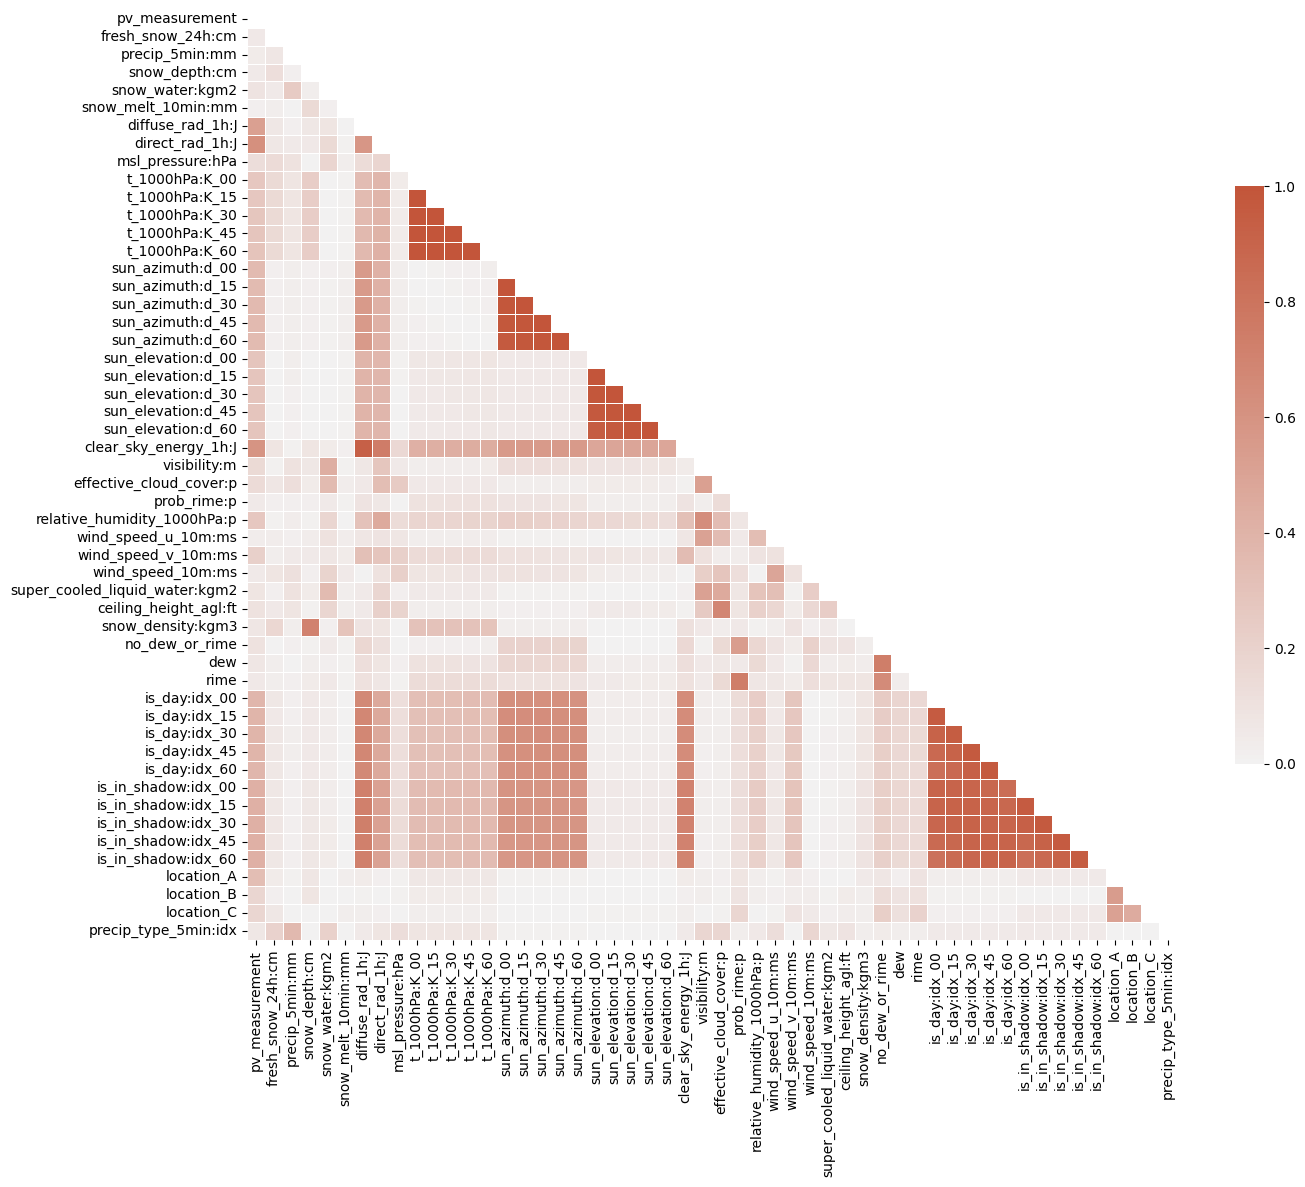

In [12]:
show_corr_matrix(dataset.drop(columns=["merge_time", "location", "id"]))

In [13]:
# snow_features = ["fresh_snow_1h:cm", "fresh_snow_3h:cm", "fresh_snow_6h:cm", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "snow_depth:cm", "snow_water:kgm2", "snow_melt_10min:mm", 'pv_measurement']

# show_corr_matrix_with_values(dataset[snow_features])

## Deleting:

- **wind_speed_u_10m:ms** and **wind_speed_v_10m:ms** because of poor correlation to pv_measurement

- **prob_rime:p** because we have a strong correlation to **dew_or_rime:idx**, effectively the true value.

- **snow_depth:cm** and **snow_melt_10min:mm** because of poor correlation to pv_measurement

- **fresh_snow_1h:cm**, **fresh_snow_3h:cm**, **fresh_snow_6h:cm**, **fresh_snow_12h:cm** because 24h seems better

In [14]:
dataset = dataset.drop(columns=['wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'prob_rime:p', 'snow_depth:cm', 'snow_melt_10min:mm'])

# Split into training set and test set

In [15]:
testset = dataset[dataset["id"].apply(lambda id: id != -10)]
testset = testset.drop(columns=["merge_time", "id", "pv_measurement", 'location'])

In [16]:
dataset = dataset[dataset["id"].apply(lambda id: id == -10)]
dataset = dataset.drop("id", axis=1)

dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.drop(columns=["pv_measurement", "merge_time", 'location'])
datasetY = dataset['pv_measurement']

display(datasetX)
display(datasetY)
display(testset)

,fresh_snow_24h:cm,precip_5min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,location_A,location_B,location_C,precip_type_5min:idx
34059,0.0,0.451489,0.254795,0.0,0.0,3.245583,42.403419,3.093626,3.078885,3.062908,3.061186,1.415586,1.380068,1.334030,1.278593,1.214569,6.695962,6.757260,6.837717,6.935586,7.046093,0.0,0.898502,2.476484,6.236157,1.676759,0.000000,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1,0,1.0
34060,0.0,1.625360,0.424658,0.0,0.0,3.187544,42.342499,3.063150,3.063642,3.062908,3.091647,1.214553,1.143976,1.067817,0.987223,0.902910,7.045794,7.172333,7.310594,7.458632,7.610935,0.0,0.716734,2.830434,6.180139,2.067237,0.000000,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0.0
34061,0.0,0.000000,0.424658,0.0,0.0,3.178380,42.372963,3.063150,3.048399,3.032430,3.030724,0.902899,0.816362,0.728168,0.638946,0.549027,7.610612,7.770825,7.934819,8.100680,8.263182,0.0,0.594172,2.811223,6.105916,2.342869,1.151734,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0.0
34062,0.0,0.541787,0.424658,0.0,0.0,3.202818,42.312035,3.002193,2.972189,2.956238,2.939349,0.549019,0.459223,0.369718,0.280794,0.192563,8.262832,8.426480,8.587411,8.744496,8.892535,0.0,0.351146,2.821120,6.226354,2.928586,1.919557,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1,0,1.0
34063,0.0,0.000000,0.424658,0.0,0.0,3.245588,42.220650,2.971712,3.017913,3.062908,3.122104,0.192560,0.105338,0.019221,-0.065739,-0.149383,8.892158,9.036927,9.174846,9.305390,9.423849,0.0,0.340719,2.807148,6.397208,3.491334,1.535645,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34057,0.0,0.000000,0.169863,0.0,0.0,5.347198,41.794178,2.499285,2.484443,2.468614,2.482456,1.380460,1.406680,1.427252,1.441995,1.450246,10.059494,10.044254,10.032437,10.024459,10.016190,0.0,0.746678,2.858959,5.545740,2.308415,0.959778,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0.0
88800,0.0,0.000000,0.339727,0.0,0.0,5.354833,41.778946,2.468809,2.469205,2.468614,2.467225,1.380420,1.406648,1.427228,1.441983,1.450240,10.058306,10.042979,10.031085,10.023076,10.014753,0.0,0.643039,2.872931,5.573749,1.826060,1.343690,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0.0
34058,0.0,1.354467,0.169863,0.0,0.0,5.319707,41.763718,2.468809,2.469205,2.483848,2.421533,1.450228,1.452769,1.449247,1.439693,1.428334,10.015766,10.014797,10.018202,10.025946,10.041159,0.0,0.871704,2.761740,5.597557,2.182084,0.575867,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0.0
62731,0.0,0.000000,0.169863,0.0,0.0,5.324285,41.763718,2.468809,2.484443,2.483848,2.421533,1.450229,1.452769,1.449247,1.439693,1.428329,10.015766,10.014797,10.018239,10.025946,10.041194,0.0,0.890395,2.761740,5.597557,2.182084,0.575867,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0.0


34059    0.0
34060    0.0
34061    0.0
34062    0.0
34063    0.0
        ... 
34057    0.0
88800   -0.0
34058    0.0
62731   -0.0
88801   -0.0
Name: pv_measurement, Length: 88802, dtype: float64

,fresh_snow_24h:cm,precip_5min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,location_A,location_B,location_C,precip_type_5min:idx
88802,0.0,0.0,0.0,0.000000,0.000000,5.287630,41.702789,2.407847,2.408233,2.407657,2.421533,1.428315,1.408388,1.382824,1.351836,1.315191,10.040734,10.053665,10.069989,10.089091,10.105955,0.000000,1.673153,2.120788,5.619963,2.262476,0.000000,2,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0.0
88803,0.0,0.0,0.0,0.000000,0.000000,5.249447,41.702789,2.407847,2.408233,2.407657,2.421533,1.315174,1.273961,1.228158,1.178091,1.123636,10.105527,10.126887,10.148997,10.171050,10.187660,0.000000,1.655224,2.353650,5.580751,2.182084,0.000000,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0.0
88804,0.0,0.0,0.0,0.000000,0.000000,5.212792,41.702789,2.407847,2.423476,2.422896,2.436764,1.123622,1.065788,1.004634,0.940414,0.873113,10.187229,10.205076,10.220292,10.231989,10.234810,0.000000,1.769928,2.488127,5.433705,2.090207,0.000000,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0.0
88805,0.0,0.0,0.0,0.259269,0.048338,5.173080,41.718021,2.423087,2.423476,2.422896,2.436764,0.873102,0.803500,0.731632,0.657693,0.581678,10.234376,10.235101,10.230003,10.218361,10.195100,0.071788,1.953625,1.938574,5.286659,1.998329,0.000000,3,0,1,0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0.0
88806,0.0,0.0,0.0,0.872209,0.304753,5.141007,41.718021,2.423087,2.423476,2.438135,2.451995,0.581670,0.504122,0.425057,0.344587,0.262773,10.194668,10.166797,10.130967,10.086741,10.029557,0.385523,1.981853,2.003775,5.178825,1.906452,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90957,0.0,0.0,0.0,0.503549,0.097438,3.654913,43.713299,4.404229,4.389692,4.373407,4.370947,0.766926,0.834805,0.900325,0.963330,1.023245,10.073949,10.115916,10.150972,10.179651,10.198044,0.323764,2.290533,2.528296,5.041582,1.240343,0.767823,4,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.0
90958,0.0,0.0,0.0,0.203930,0.026094,3.685457,43.652374,4.343271,4.328725,4.312450,4.294798,1.023232,1.080435,1.134499,1.185176,1.231789,10.197612,10.213927,10.225865,10.234088,10.234786,0.086470,2.339468,2.218590,5.318869,1.286281,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0,0,1,0.0
90959,0.0,0.0,0.0,0.041101,0.000000,3.714476,43.576218,4.267074,4.252515,4.236258,4.218649,1.231773,1.274789,1.313714,1.348319,1.377881,10.234352,10.235777,10.235607,10.234429,10.228321,0.001655,2.307512,2.434569,5.675982,1.263312,0.000000,3,0,1,0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0.0
90960,0.0,0.0,0.0,0.000000,0.000000,3.738914,43.500061,4.190876,4.176305,4.160067,4.157731,1.377863,1.402998,1.423226,1.438410,1.447899,10.227888,10.224919,10.222558,10.221124,10.216395,0.000000,2.188311,2.910771,5.872043,1.056588,0.767823,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0.0


In [17]:
datasetY.describe()

count    88802.000000
mean       296.168614
std        782.979492
min         -0.000000
25%          0.000000
50%          0.000000
75%        166.600000
max       5733.420000
Name: pv_measurement, dtype: float64

In [18]:
datasetX.describe()

,fresh_snow_24h:cm,precip_5min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,location_A,location_B,location_C,precip_type_5min:idx
count,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000
mean,0.194605,0.204903,0.381782,0.641898,0.437748,4.963515,42.548038,3.253536,3.253988,3.253165,3.266553,-0.007055,-0.007044,-0.007052,-0.007080,-0.006869,9.357030,9.357693,9.358757,9.360180,9.357558,0.608230,1.865491,1.948071,5.153320,1.736411,0.535101,-114.519853,0.046598,0.937524,0.034583,0.027894,0.478593,0.478739,0.477985,0.478593,0.478480,0.571034,0.569796,0.569830,0.569830,0.571170,0.383539,0.322887,0.293574,0.118027
std,1.011644,0.999194,1.003364,0.985464,0.981016,1.001647,0.994533,0.994506,0.994496,0.994464,0.994451,0.999988,0.999988,0.999987,0.999986,0.999980,0.992900,0.992897,0.992893,0.992886,0.992899,0.981696,1.003192,0.997640,0.997219,1.000360,0.998862,255.270155,0.210778,0.242020,0.182721,0.164669,0.499544,0.499551,0.499518,0.499544,0.499539,0.494931,0.495107,0.495103,0.495103,0.494912,0.486250,0.467583,0.455402,0.476447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.281044,0.000000,0.000000,0.000000,0.000000,-1.452724,-1.452796,-1.452911,-1.451504,-1.452743,6.581895,6.573701,6.577538,6.600884,6.582173,0.000000,0.007458,0.000000,1.372431,0.011485,0.000000,-666.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.340685,41.855099,2.575483,2.560653,2.560040,2.573831,-0.979802,-0.966761,-0.973186,-0.986413,-0.979590,8.805812,8.792148,8.798096,8.810562,8.806185,0.000000,0.970428,1.207970,4.494010,0.953226,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.037452,0.000000,5.027986,42.433884,3.139348,3.139852,3.139100,3.152565,-0.014756,-0.008013,-0.017154,-0.021264,-0.014516,9.790885,9.785412,9.788582,9.789922,9.791561,0.003276,2.074853,2.317556,5.315368,1.550428,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.424658,1.058282,0.263081,5.654194,43.241131,3.947042,3.947675,3.931491,3.944511,0.963773,0.977018,0.969405,0.955846,0.963833,10.160769,10.158435,10.160247,10.165713,10.161226,0.899467,2.721104,2.868856,5.951868,2.319900,0.959778,4.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,30.407444,27.992313,25.054831,5.418017,5.976809,7.604596,46.195969

In [23]:
#!ReWrite
# OSCAR
# def evaluate_models(models, numerical_features, categorical_features, Y):
#     preds = numerical_features.iloc[:,1:2]

#     for i in range(len(models)):
#         preds[str(i)] = models[i].predict([numerical_features, categorical_features])


#     preds = preds.iloc[:,1:]


#     preds["final"] = preds.mean(axis=1)
#     preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
#     return preds["losses"].mean()

# SONDRE
def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

In [20]:
# OSCAR
# def get_predictions(models, numerical_features, categorical_features):
#     preds = numerical_features.iloc[:,1:2]

#     for i in range(len(models)):
#         preds[str(i)] = models[i].predict([numerical_features, categorical_features], verbose=0)


#     preds = preds.iloc[:,1:]
#     return preds.mean(axis=1)

# SONDRE
def get_predictions(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X, verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)

In [21]:
# OSCAR
# def emb_sz_rule(n_cat):
#     return min(600, round(1.6 * n_cat**0.56))

In [24]:
# OSCAR
# from tensorflow.keras import layers

# num_folds = 9

# losses = []
# models = []
# for f in range(0, num_folds):
#   evalIndex=f*10000
#   evalSize=10000

#   #partition into training and evalset
#   trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
#   trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
#   evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
#   evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

#   # Assuming you have a DataFrame df with categorical features (e.g., 'location', 'day_of_week')

#   # Separate numerical and categorical features
#   categorical_features_labels = ['precip_type_5min:idx']

#   categorical_features = trainsetX[categorical_features_labels]
#   numerical_features = trainsetX.drop(columns=categorical_features_labels)

#   categorical_features_eval = evalsetX[categorical_features_labels]
#   numerical_features_eval = evalsetX.drop(columns=categorical_features_labels)

#   numModels = 20

#   models = []

#   i = 0
#   while(i < numModels):

#     # Create input layers for numerical and categorical features
#     numerical_input = layers.Input(shape=(int(numerical_features.shape[1]),), name='numerical_input')
#     categorical_input = layers.Input(shape=(int(categorical_features.shape[1]),), name='categorical_input', dtype=tf.int32)

#     # Embedding layer for categorical features
#     num_categories = 7  # adjust as needed
#     embedding_layer = layers.Embedding(input_dim=num_categories, output_dim=int(emb_sz_rule(num_categories)), input_length=int(categorical_features.shape[1]))(categorical_input)
#     flatten_embedding = layers.Flatten()(embedding_layer)

#     # Concatenate numerical and flattened categorical features
#     concatenated_features = layers.concatenate([numerical_input, flatten_embedding])


#     if(i < 10):
#       # Dense layers
#       dense_1 = layers.Dense(70, activation="tanh",
#               kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
#                                   bias_initializer=tf.keras.initializers.Zeros())(concatenated_features)
#       dense_2 = layers.Dense(70, activation="relu",
#               kernel_initializer=tf.keras.initializers.GlorotNormal())(dense_1)
#       output_layer = layers.Dense(1, activation="relu",
#               kernel_initializer=tf.keras.initializers.GlorotNormal())(dense_2)
      
#       # Create the model
#       model = tf.keras.models.Model(inputs=[numerical_input, categorical_input], outputs=output_layer)
#       models.append(model)
#     else:
#       # Dense layers
#       dense_1 = layers.Dense(100, activation="tanh",
#                   kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
#                                       bias_initializer=tf.keras.initializers.Zeros())(concatenated_features)
#       dense_2 = layers.Dense(80, activation="relu",
#                   kernel_initializer=tf.keras.initializers.GlorotNormal(),
#                                       bias_initializer=tf.keras.initializers.Zeros())(dense_1)
#       dense_3 = layers.Dense(60, activation="relu",
#                   kernel_initializer=tf.keras.initializers.GlorotNormal(),
#                                       bias_initializer=tf.keras.initializers.Zeros())(dense_2)
#       dense_4 = layers.Dense(40, activation="relu",
#                   kernel_initializer=tf.keras.initializers.GlorotNormal(),
#                                       bias_initializer=tf.keras.initializers.Zeros())(dense_3)
#       dense_5 = layers.Dense(20, activation="relu",
#                   kernel_initializer=tf.keras.initializers.GlorotNormal(),
#                                       bias_initializer=tf.keras.initializers.Zeros())(dense_4)
#       output_layer = layers.Dense(1, activation="relu",
#                   kernel_initializer=tf.keras.initializers.GlorotNormal(),
#                                       bias_initializer=tf.keras.initializers.Zeros())(dense_5)

#       # Create the model
#       model = tf.keras.models.Model(inputs=[numerical_input, categorical_input], outputs=output_layer)
#       models.append(model)

#     models[i].compile(
#         optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1,
#                                                             #weight_decay=0.0001
#                                                             ),
#         loss="mean_absolute_error"
#     )

#     history = models[i].fit(
#                         x=[
#                         numerical_features.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
#                         categorical_features.sample(frac=0.8 if i < 10 else 0.8, random_state=i)
#                         ],
#                         y=trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
#                         batch_size = 1000,
#                         epochs = 1,
#                         verbose = 0,
#                     )

#     #retry if model is nonsensical
#     loss = models[i].evaluate([numerical_features_eval, categorical_features_eval], evalsetY, verbose=0)
#     if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
#       print("discarding")
#       del models[i]
#       continue

#     history = models[i].fit(
#                         x=[
#                         numerical_features.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
#                         categorical_features.sample(frac=0.8 if i < 10 else 0.8, random_state=i)
#                         ],
#                         y=trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
#                         batch_size = 1000,
#                         epochs = 1,
#                         verbose = 0,
#                     )
#     loss = models[i].evaluate([numerical_features_eval, categorical_features_eval], evalsetY)
#     print(i, " complete")
#     i+=1

#   loss = evaluate_models(models, numerical_features_eval, categorical_features_eval, evalsetY)
#   print(loss)
#   losses.append(loss)

# print(losses)







# SONDRE

num_folds = 9

losses = []
models = []
for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  numModels = 20

  models = []



  i = 0
  while(i < numModels):
    if(i < 10):
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(70, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(70, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
        ]))
    else:
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(100, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(80, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(60, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(40, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(20, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
        ]))
    models[i].compile(
        optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        y = trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                        #validation_data = [evalsetX, evalsetY]
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        y = trainsetY.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        batch_size = 1000,
                        epochs = 40,
                        verbose = 0,
                        validation_data = [evalsetX, evalsetY]
                    )
    loss = models[i].evaluate(evalsetX, evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, evalsetX, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)


discarding
discarding
313/313 [==============================] - 0s 268us/step - loss: 154.7985
0  complete
discarding
discarding
discarding
discarding
discarding
313/313 [==============================] - 0s 270us/step - loss: 157.3986
1  complete
313/313 [==============================] - 0s 305us/step - loss: 155.4340
2  complete
discarding
313/313 [==============================] - 0s 277us/step - loss: 152.0588
3  complete
discarding
discarding
313/313 [==============================] - 0s 273us/step - loss: 133.2226
4  complete
discarding
313/313 [==============================] - 0s 272us/step - loss: 139.0872
5  complete
313/313 [==============================] - 0s 268us/step - loss: 150.0871
6  complete
discarding
discarding
discarding
313/313 [==============================] - 0s 271us/step - loss: 156.0533
7  complete
discarding
discarding
313/313 [==============================] - 0s 272us/step - loss: 140.0446
8  complete
313/313 [==============================] - 0s 272u

In [25]:
evalsetX.describe()

,fresh_snow_24h:cm,precip_5min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,location_A,location_B,location_C,precip_type_5min:idx
count,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000
mean,0.554594,0.152015,0.354808,0.481593,0.302610,5.080863,41.840633,2.545567,2.545655,2.544617,2.558683,-0.050347,-0.050200,-0.050068,-0.049954,-0.049586,9.413806,9.414218,9.415044,9.416240,9.414201,0.380119,1.781749,2.027321,5.007191,1.795829,0.359530,-133.529539,0.075778,0.945126,0.012611,0.042263,0.393433,0.395706,0.393320,0.392865,0.392979,0.658146,0.659055,0.656328,0.657464,0.658828,0.418087,0.330152,0.251761,0.089639
std,1.422042,0.650035,0.805558,0.844219,0.808416,1.177277,0.611427,0.611034,0.610926,0.610996,0.610926,0.999629,0.999667,0.999688,0.999693,0.999685,0.926427,0.926631,0.926815,0.926980,0.926516,0.719142,0.915366,1.043376,1.010885,1.042745,0.801710,269.990696,0.264658,0.227747,0.111594,0.201200,0.488539,0.489029,0.488514,0.488415,0.488440,0.474358,0.474054,0.474960,0.474585,0.474130,0.493273,0.470294,0.434049,0.434596
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.023715,39.555206,0.274310,0.274354,0.259054,0.274139,-1.452117,-1.452796,-1.452911,-1.450900,-1.452136,6.589826,6.578903,6.589441,6.620806,6.590105,0.000000,0.011232,0.000000,1.491468,0.034454,0.000000,-666.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.218495,41.459095,2.164018,2.164365,2.163847,2.177860,-1.015981,-1.018690,-1.023946,-1.022441,-1.013453,8.940095,8.948864,8.937043,8.930283,8.940996,0.000000,1.052277,1.278265,4.372172,0.953226,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,5.066169,41.839874,2.545006,2.545415,2.544806,2.558605,-0.083005,-0.102114,-0.107117,-0.093327,-0.080145,9.803627,9.797724,9.800376,9.803240,9.802938,0.000000,1.834192,2.575159,5.167622,1.584882,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.424658,0.662671,0.058829,6.031445,42.251110,2.956471,2.956946,2.956238,2.969806,0.928232,0.921061,0.910336,0.912985,0.928791,10.149231,10.149088,10.151387,10.151154,10.149360,0.357557,2.463827,2.909025,5.769811,2.469200,0.191956,4.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.032892,8.939483,9.087684,4.911842,4.631936,7.404524,43.439140,4.129919,4.130581,4.129592,4.157731,1.452115,1.

In [26]:
# OSCAR
# preds = get_predictions(models, numerical_features_eval, categorical_features_eval)

# SONDRE
preds = get_predictions(models, evalsetX)


In [27]:
preds.describe()

count    8802.000000
mean      131.569916
std       402.531952
min         0.000000
25%         0.000000
50%         0.201584
75%        37.002474
max      4438.909180
dtype: float64

In [28]:
comparison = dataset[["location", "merge_time", "pv_measurement"]]
comparison = comparison.iloc[80000:88802,:]
comparison["pv_pred"] = preds
comparison = comparison.rename(columns={"pv_measurement": "pv_true"})

comparisonA = comparison[comparison["location"].apply(lambda loc: loc == "A")]
comparisonB = comparison[comparison["location"].apply(lambda loc: loc == "B")]
comparisonC = comparison[comparison["location"].apply(lambda loc: loc == "C")]

comparison.describe()

# display(comparison.describe())

,merge_time,pv_true,pv_pred
count,8802,8802.000000,8802.000000
mean,2023-02-20 18:45:54.192229,186.186764,131.569916
min,2022-11-27 15:00:00,-0.000000,0.000000
25%,2023-01-18 15:15:00,0.000000,0.000000
50%,2023-02-22 02:00:00,0.000000,0.201584
75%,2023-03-31 10:00:00,47.987866,37.002474
max,2023-04-30 23:00:00,5172.640000,4438.909180
std,NaN,639.877500,402.531952


<Axes: title={'center': 'C'}, xlabel='merge_time'>

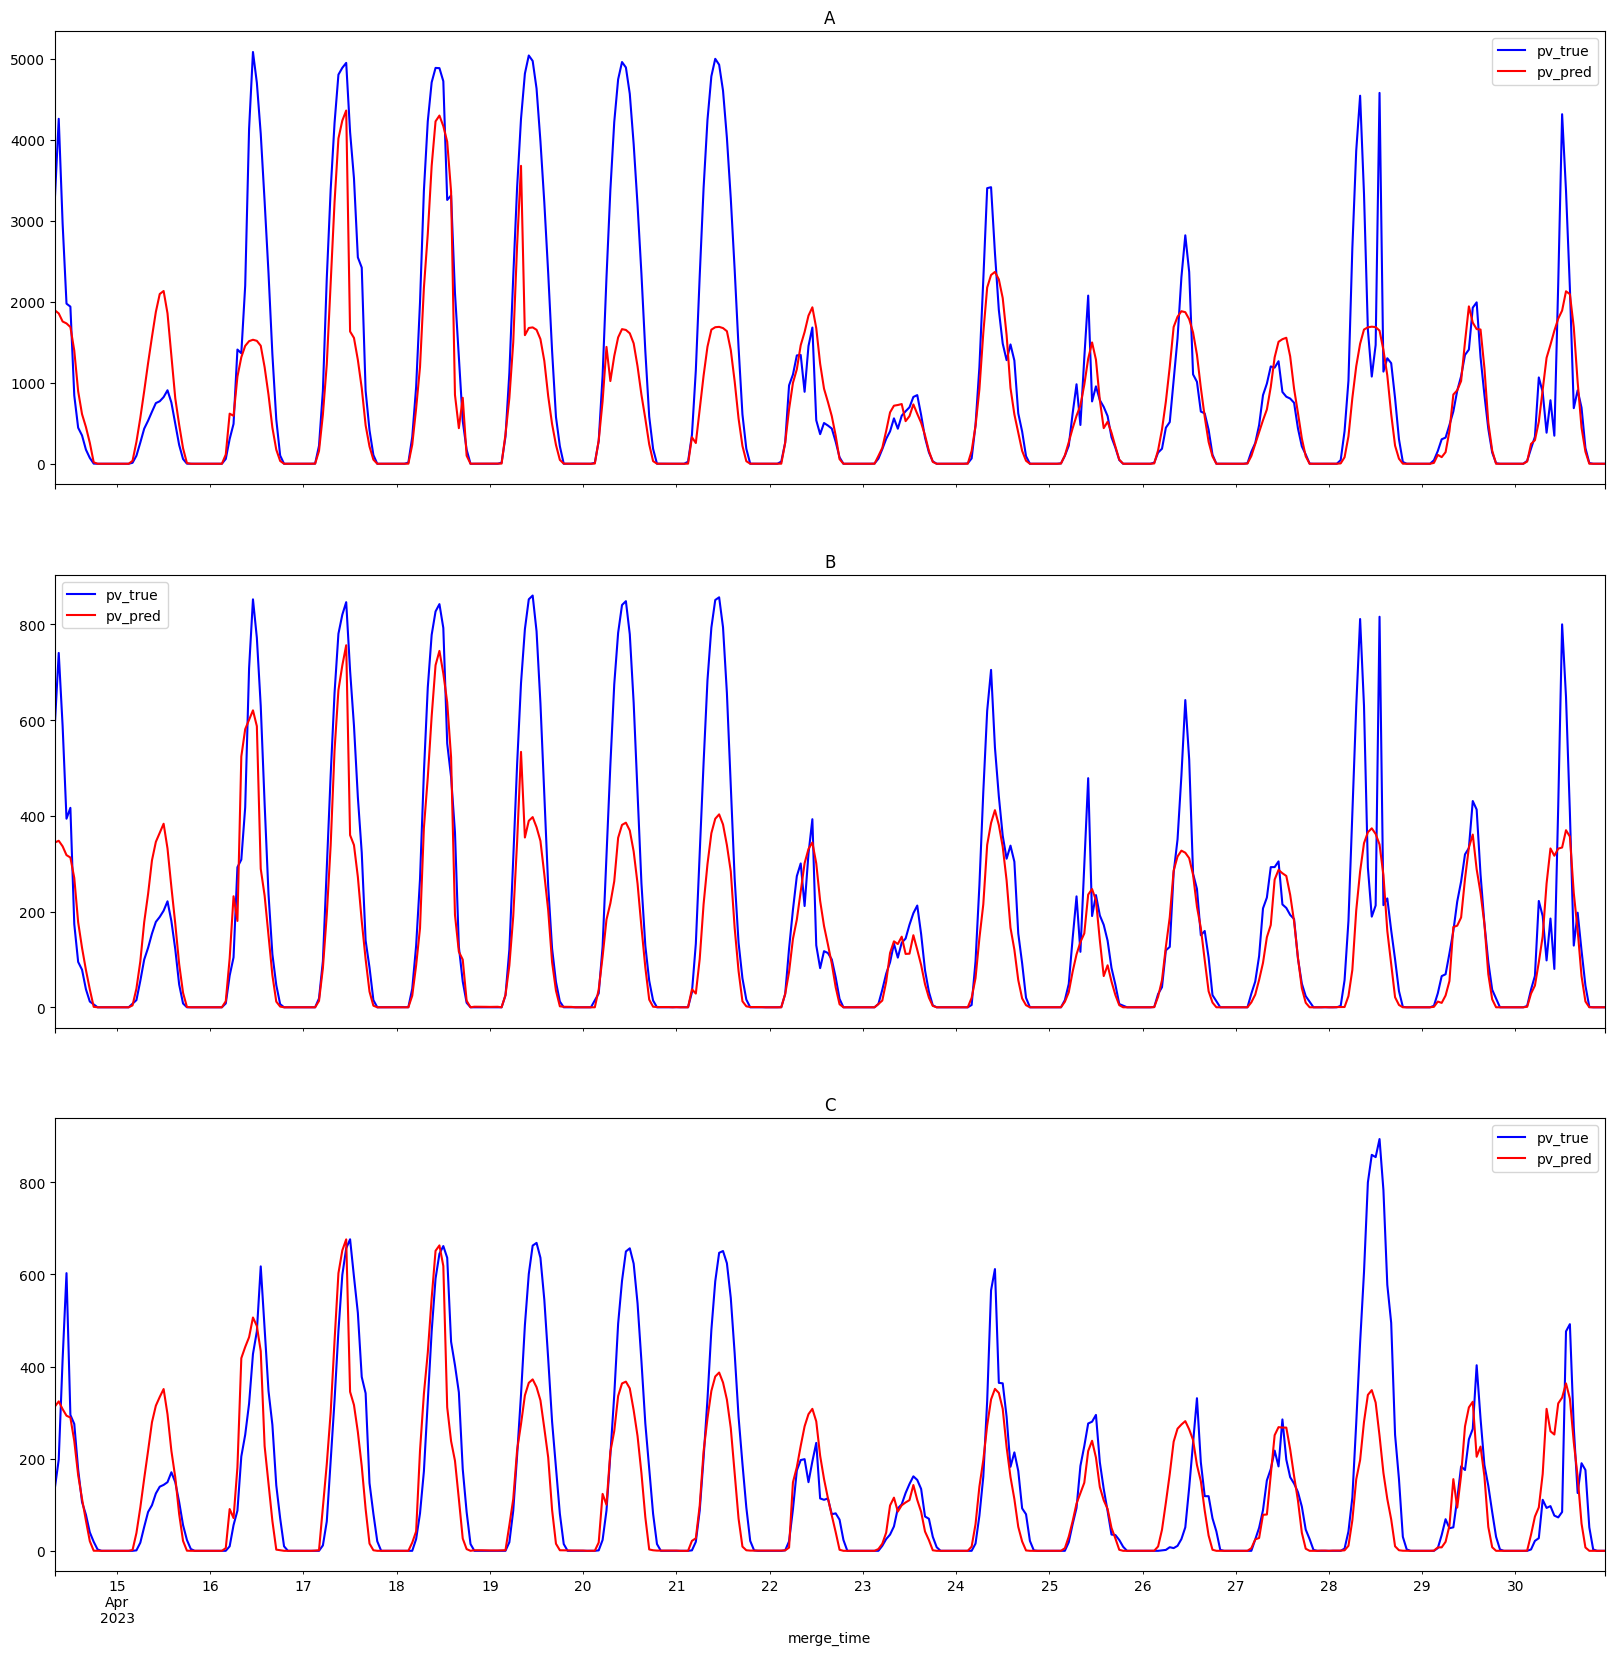

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

comparisonA.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[0], title='A', color='blue')
comparisonA.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[0], title='A', color='red')
comparisonB.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[1], title='B', color='blue')
comparisonB.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[1], title='B', color='red')
comparisonC.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[2], title='C', color='blue')
comparisonC.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[2], title='C', color='red')

In [69]:
testset.describe()
# predictions = get_predictions(models, testset)
# predictions.describe()

,fresh_snow_24h:cm,precip_5min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,location_A,location_B,location_C,precip_type_5min:idx
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.0,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000
mean,0.000376,0.275492,0.257469,1.400946,1.005321,5.529912,43.368729,4.076050,4.077529,4.077979,4.091839,0.144334,0.144321,0.144297,0.144264,0.144575,9.098896,9.099497,9.100457,9.101742,9.099235,1.474505,1.871211,1.864036,4.959005,1.691694,0.621901,-173.389352,0.0,0.960648,0.037963,0.001389,0.795833,0.790278,0.792593,0.795370,0.795833,0.245370,0.237963,0.245833,0.235648,0.245370,0.333333,0.333333,0.333333,0.066204
std,0.012612,1.030478,0.841535,1.274688,1.494216,0.742670,0.889435,0.889030,0.888553,0.888874,0.889078,0.989466,0.989482,0.989514,0.989561,0.989791,1.231802,1.231885,1.232025,1.232208,1.231814,1.326450,0.858749,1.089704,1.091796,0.984318,1.042417,295.016152,0.0,0.194476,0.191151,0.037251,0.403185,0.407205,0.405544,0.403524,0.403185,0.430406,0.425935,0.430680,0.424502,0.430406,0.471514,0.471514,0.471514,0.250551
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.192130,41.687561,2.392611,2.392995,2.392422,2.406307,-1.447435,-1.452796,-1.451221,-1.438621,-1.447454,6.592422,6.574933,6.579180,6.605118,6.592702,0.000000,0.078567,0.000000,1.726742,0.068908,0.000000,-666.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.168450,0.000212,5.127262,42.616657,3.337460,3.337996,3.337197,3.350550,-0.791279,-0.786294,-0.780776,-0.739076,-0.791289,8.054115,7.963730,7.974208,8.101390,8.054456,0.077269,1.092602,0.902194,4.216723,0.861349,0.000000,-666.000000,0.0,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.248932,0.147633,5.805399,43.378212,4.084197,4.084852,4.083875,4.096808,0.221907,0.258141,0.246404,0.246234,0.221910,9.703956,9.640259,9.648543,9.737733,9.704367,1.268604,2.082185,2.270984,5.149416,1.596367,0.000000,3.000000,0.0,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.021233,2.237580,1.678139,6.066572,43.911301,4.602345,4.618322,4.601982,4.614625,1.062489,1.096730,1.089048,1.059808,1.062502,10.196774,10.200374,10.205531,10.200145,10.196943,2.848780,2.541949,2.910189,5.852787,2.296930,0.959778,3.000000,0.0,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,0.487820,9.210375,12.739744,4.978049,5.873071,6.500335,46.028427,6.720642,6.721720,6.735351,6.746793,1.450722,1.452796,1.451791,1.445850,1.450740,10.23514

# Write Test Predictions to CSV

In [68]:
test_preds = pd.read_csv("sample_submission.csv")
test_preds["prediction"] = predictions.reset_index(drop=True)
test_preds.to_csv("MLPRegressor_1.csv", index=False)

90942     40.486912
90943     63.782249
90944    120.080246
90945    183.008636
90946    326.970703
90947    493.752869
90948    574.336121
90949    634.073364
90950    609.332214
90951    446.302246
90952    301.826660
90953    184.743378
90954    151.076935
90955     89.931984
90956     40.971802
90957     14.785893
90958      3.899780
90959      0.292577
90960      0.085874
90961      0.019754
dtype: float32

In [67]:
display(test_preds)

,id,prediction
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,25.509247
4,4,380.655121
...,...,...
2155,2155,14.785893
2156,2156,3.899780
2157,2157,0.292577
2158,2158,0.085874
